In [115]:
import warnings

from cvxopt.modeling import variable

warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

sns.set(style='whitegrid', context='notebook', color_codes=True)

In [116]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-state: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSTD: {np.sqrt(var):>16.2f}\nSkew: {skew:>12.2f}\nKurtosis: {kurtosis:>9.2f}'
    axes[0][1].text(x=0.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x=x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)


def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('P-value')

In [117]:
sent = 'UMCSENT'
df = web.DataReader([sent, 'IPGMFN'], 'fred', '1970', '2023-04').dropna()
df.columns = ['sentiment', 'ip']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 566 entries, 1972-02-01 to 2023-02-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  566 non-null    float64
 1   ip         566 non-null    float64
dtypes: float64(2)
memory usage: 13.3 KB


,sentiment,ip
DATE,,
1972-02-01,92.8,35.8158
1972-05-01,88.6,37.3345
1972-08-01,95.2,37.0845
1972-11-01,90.7,39.3233
1973-02-01,81.9,39.9632


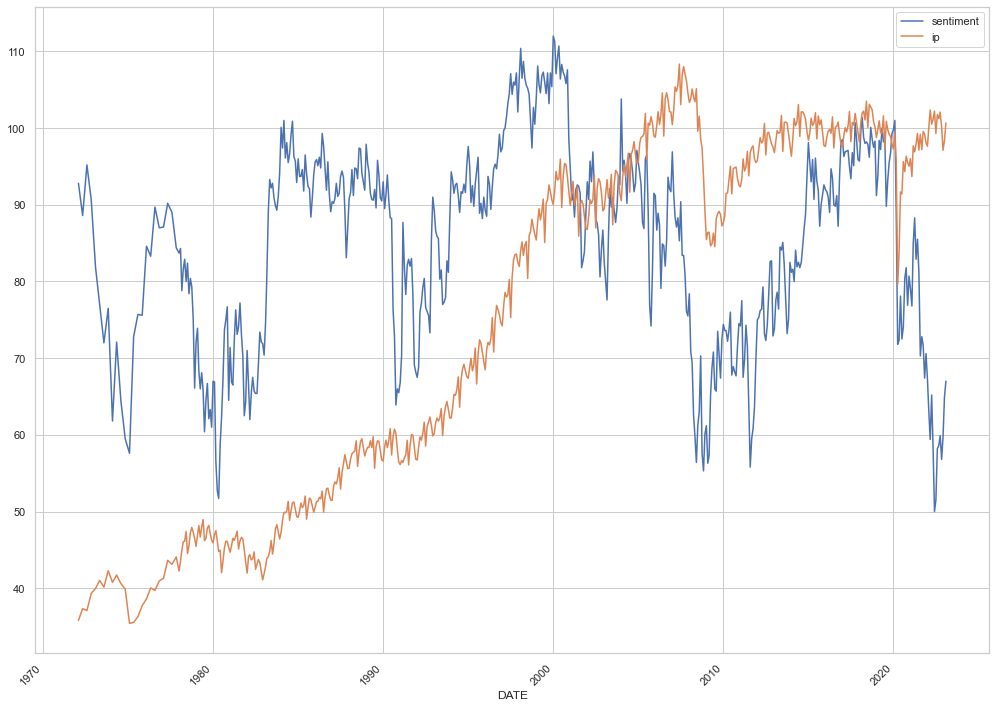

In [118]:
df.plot(subplots=False, figsize=(14, 10), rot=45)
plt.tight_layout()

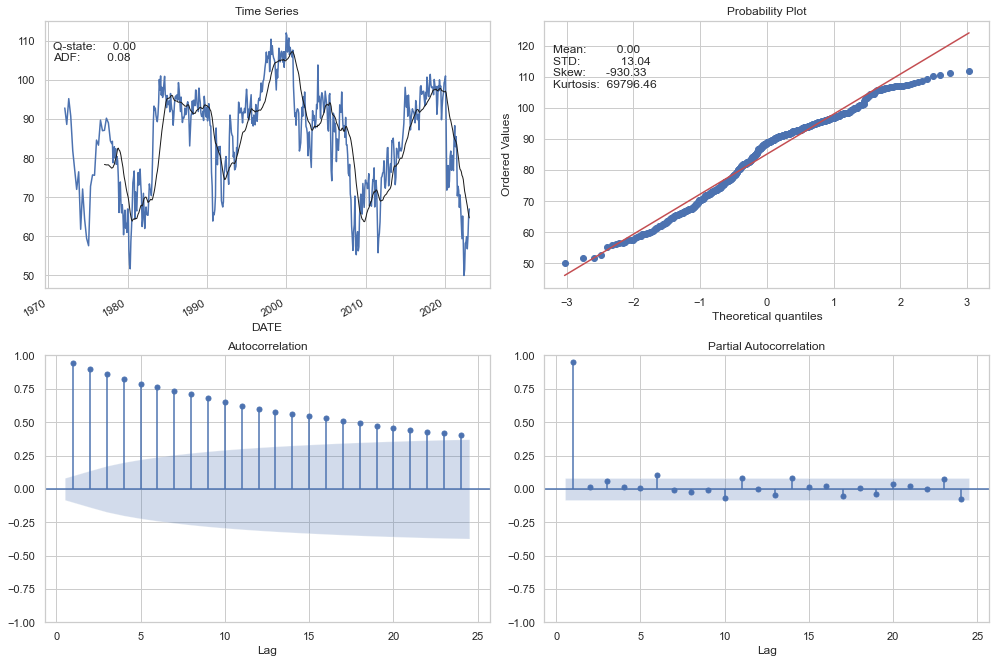

In [119]:
plot_correlogram(df.sentiment, lags=24)

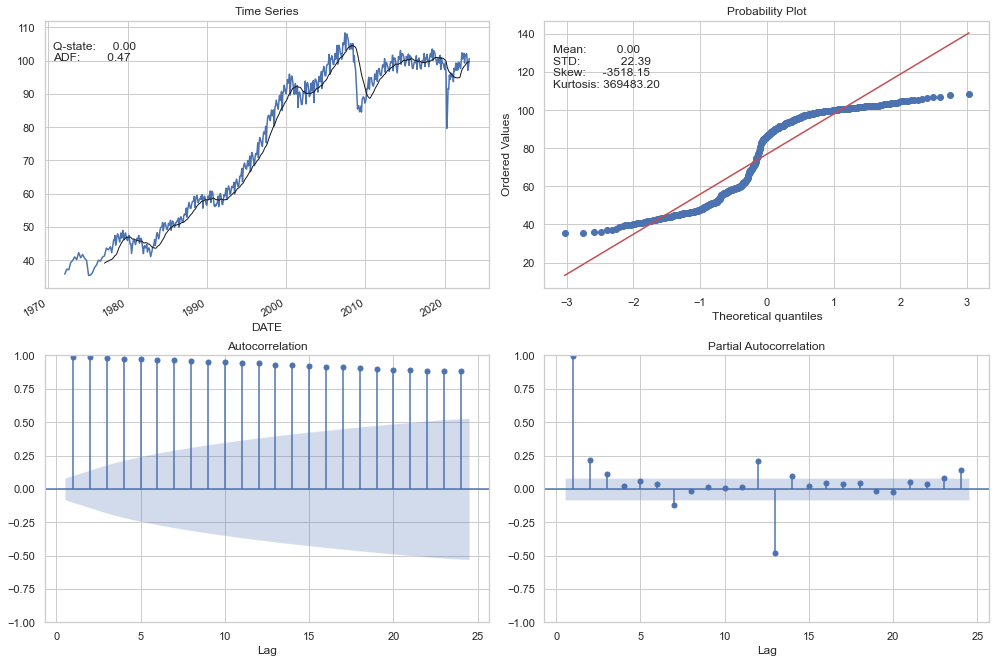

In [120]:
plot_correlogram(df.ip, lags=24)

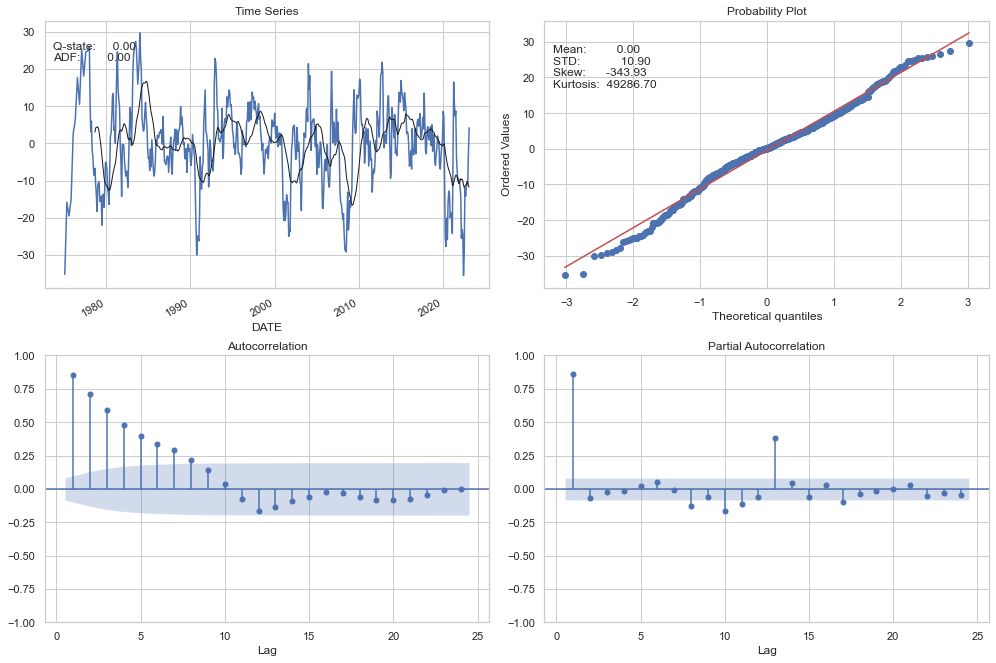

In [121]:
# log transform for stationarity
df_transformed = pd.DataFrame({'ip':np.log(df.ip).diff(12), 'sentiment':df.sentiment.diff(12)}).dropna()
plot_correlogram(df_transformed.sentiment, lags=24)

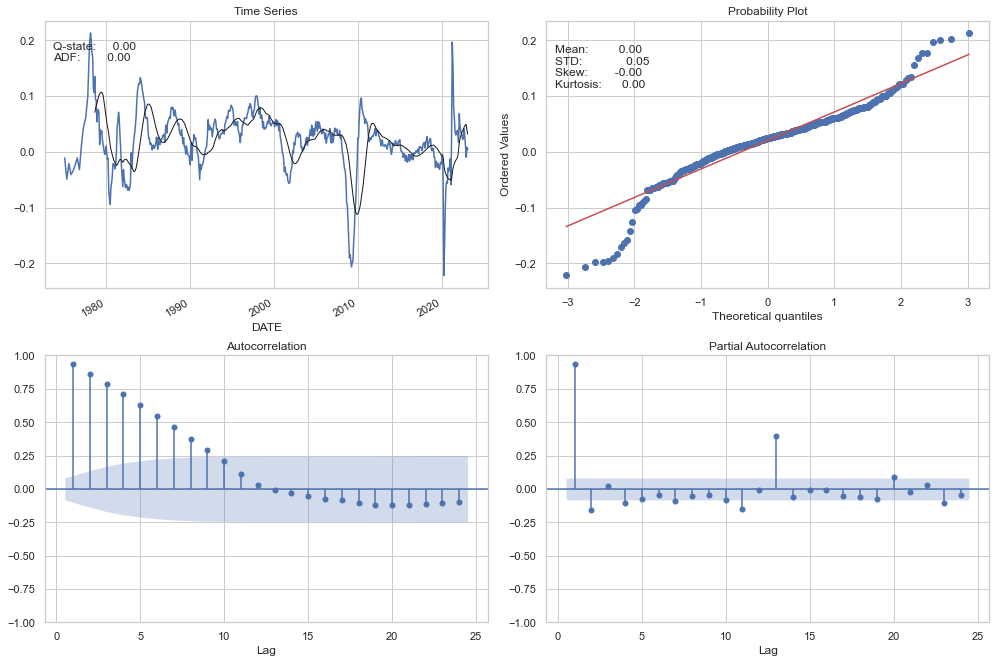

In [122]:
plot_correlogram(df_transformed.ip, lags=24)

In [123]:
pd.concat([test_unit_root(df_transformed), test_unit_root(df)], axis=1, keys=['Transform', 'Not Transform'])

,Transform,Not Transform
,P-value,P-value
ip,0.01%,46.97%
sentiment,0.01%,8.17%


array([<Axes: title={'center': 'Industrial Production'}, xlabel='DATE'>,
       <Axes: title={'center': 'Consumer Sentiment'}, xlabel='DATE'>],
      dtype=object)

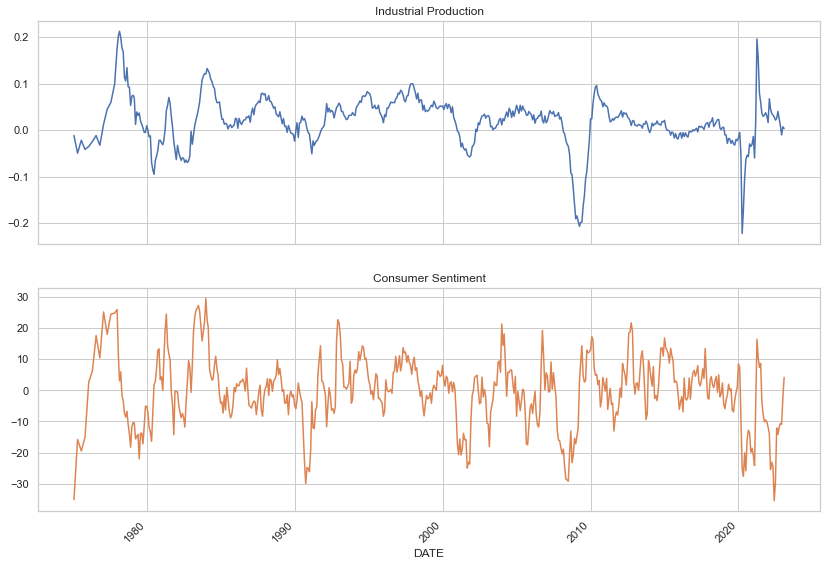

In [124]:
df_transformed.plot(subplots=True, figsize=(14, 10), title=['Industrial Production', 'Consumer Sentiment'], rot=45, legend=False)
# plt.tight_layout()

In [125]:
# Vector AR MDL
df_transformed = df_transformed.apply(minmax_scale) # coz of different scale
# trend = 'c' constant
model = VARMAX(df_transformed.loc[:'2023'], order=(1, 1), trend='c').fit(maxiter=1000)

In [126]:
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  554
Model:                      VARMA(1,1)   Log Likelihood                1585.652
                           + intercept   AIC                          -3145.304
Date:                 Thu, 27 Apr 2023   BIC                          -3089.181
Time:                         05:39:20   HQIC                         -3123.379
Sample:                              0                                         
                                 - 554                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.00, 0.28   Jarque-Bera (JB):      16254.18, 13.61
Prob(Q):                        0.97, 0.60   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.09, 1.00   Skew:                       0.24, 0.17
Prob(H) (two-sided):        

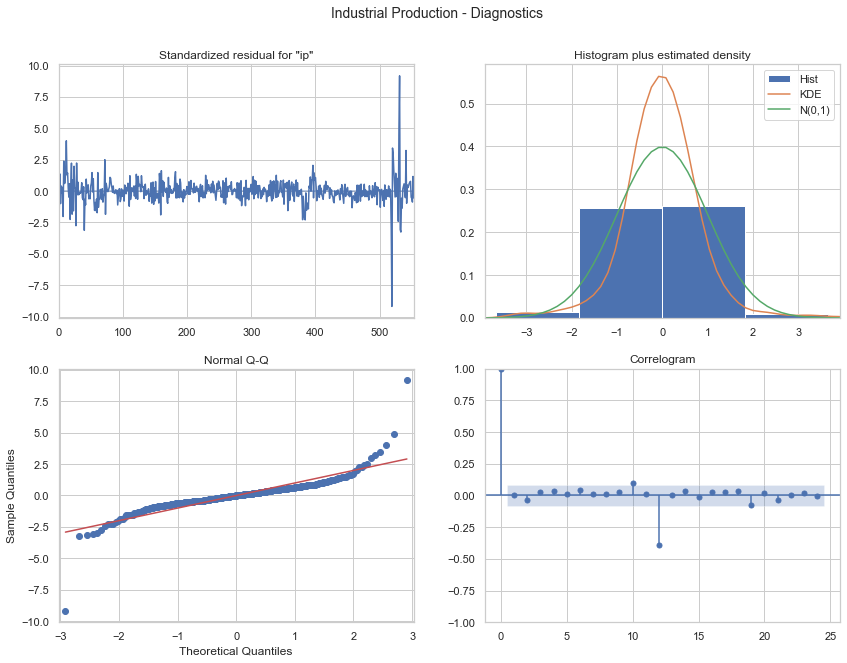

In [127]:
# Plot Diagnostics
model.plot_diagnostics(variable=0, figsize=(14, 10), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.subplots_adjust(top=.90)

Text(0.5, 1.0, 'Sentiment - Diagnostics')

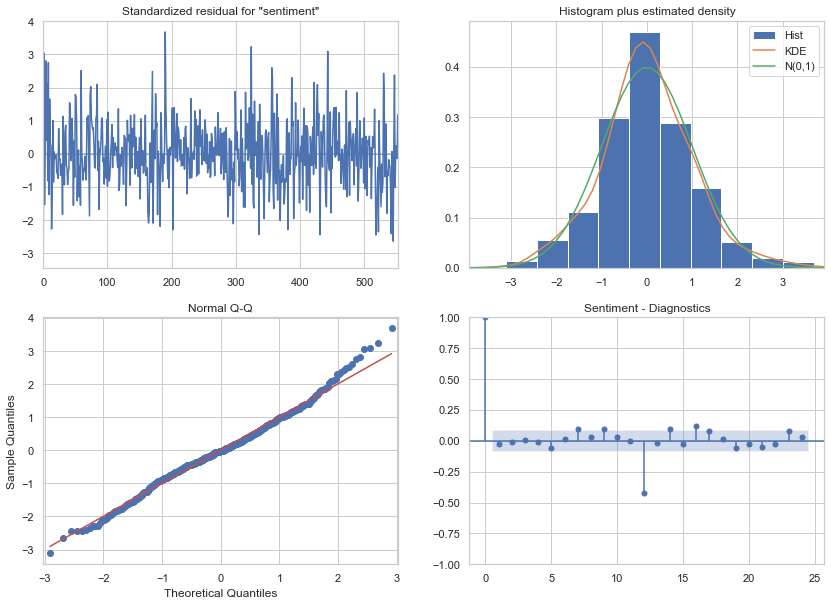

In [128]:
model.plot_diagnostics(variable=1, figsize=(14, 10), lags=24)
plt.title('Sentiment - Diagnostics')

In [129]:
df_transformed.diff().describe([.25, .5, .75])

,ip,sentiment
count,553.000000,553.000000
mean,0.000063,0.001093
std,0.043203,0.086902
min,-0.389826,-0.253067
25%,-0.019291,-0.049080
50%,-0.000821,-0.001534
75%,0.016179,0.049080
max,0.407295,0.325153


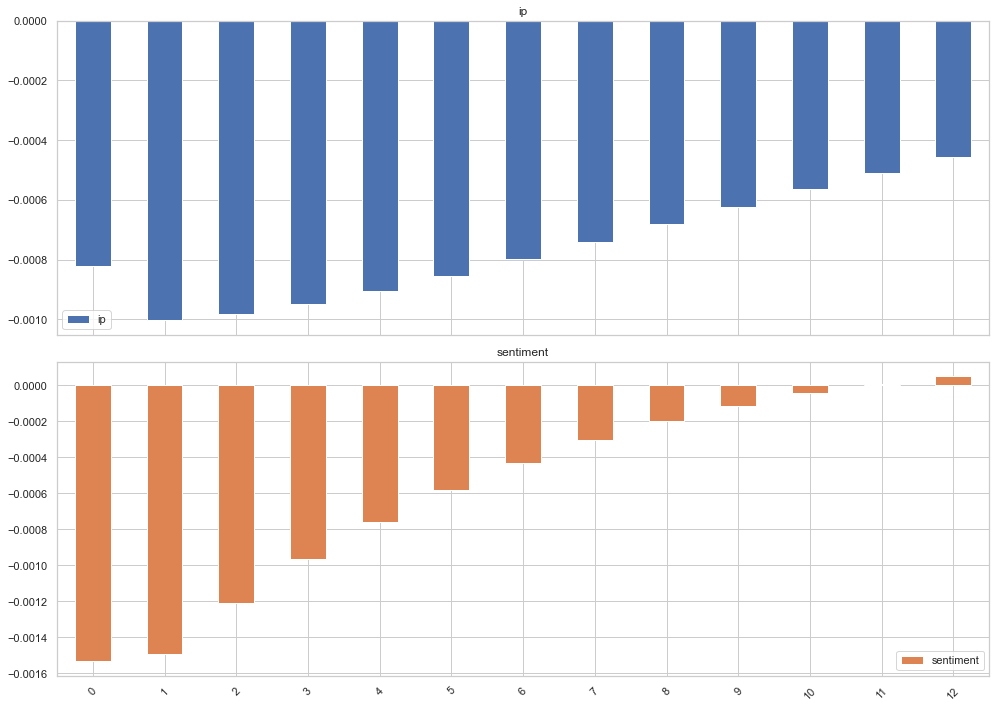

In [130]:
median_change = df_transformed.diff().quantile(.5).tolist()
# Impulse-Response function
model.impulse_responses(steps=12, impulse=median_change).plot.bar(subplots=True, figsize=(14, 10), rot=45)
plt.tight_layout()

In [131]:
model.impulse_responses(steps=12, impulse=median_change).describe()

,ip,sentiment
count,13.000000,13.000000
mean,-0.000760,-0.000583
std,0.000182,0.000565
min,-0.001001,-0.001534
25%,-0.000904,-0.000967
50%,-0.000798,-0.000429
75%,-0.000622,-0.000114
max,-0.000456,0.000053


In [132]:
n = len(df_transformed)
start = n - 24

preds = model.predict(start=start+1, end= n)

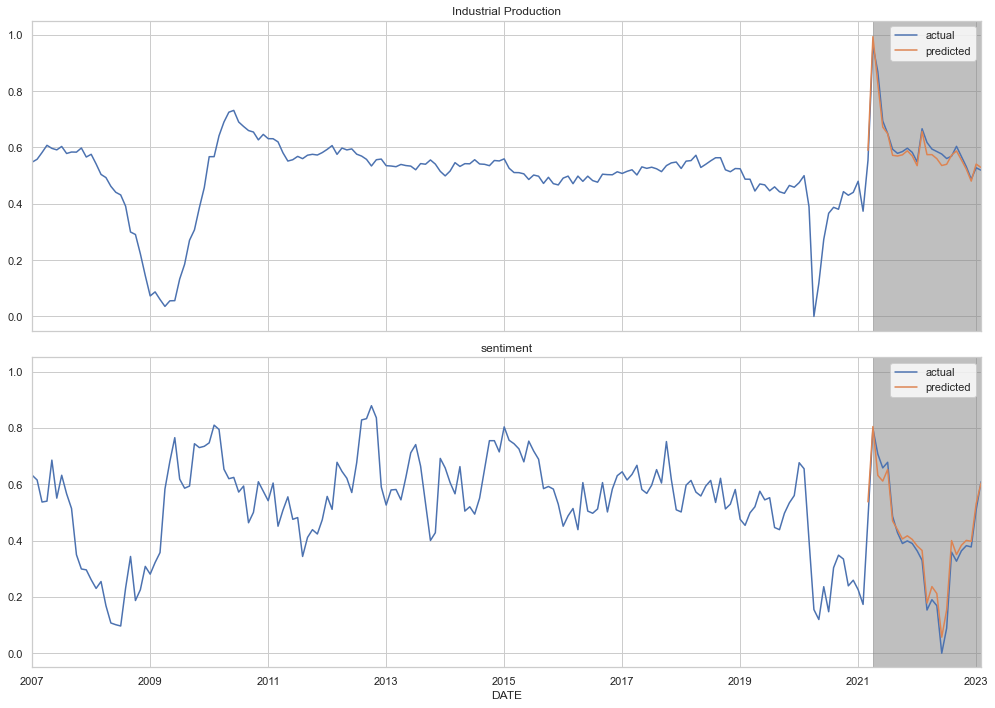

In [133]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 10), sharex=True)

df_transformed.ip.loc['2007':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans=mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2007':].plot(ax=axes[1], label='actual', title='sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].legend()
fig.tight_layout()

In [138]:
forecast = model.forecast(steps=24)
forecast

,ip,sentiment
554,0.528605,0.604724
555,0.535457,0.598370
556,0.541253,0.592256
557,0.546116,0.586443
558,0.550158,0.580973
559,0.553483,0.575870
560,0.556183,0.571150
561,0.558345,0.566816
562,0.560045,0.562864
563,0.561351,0.559285


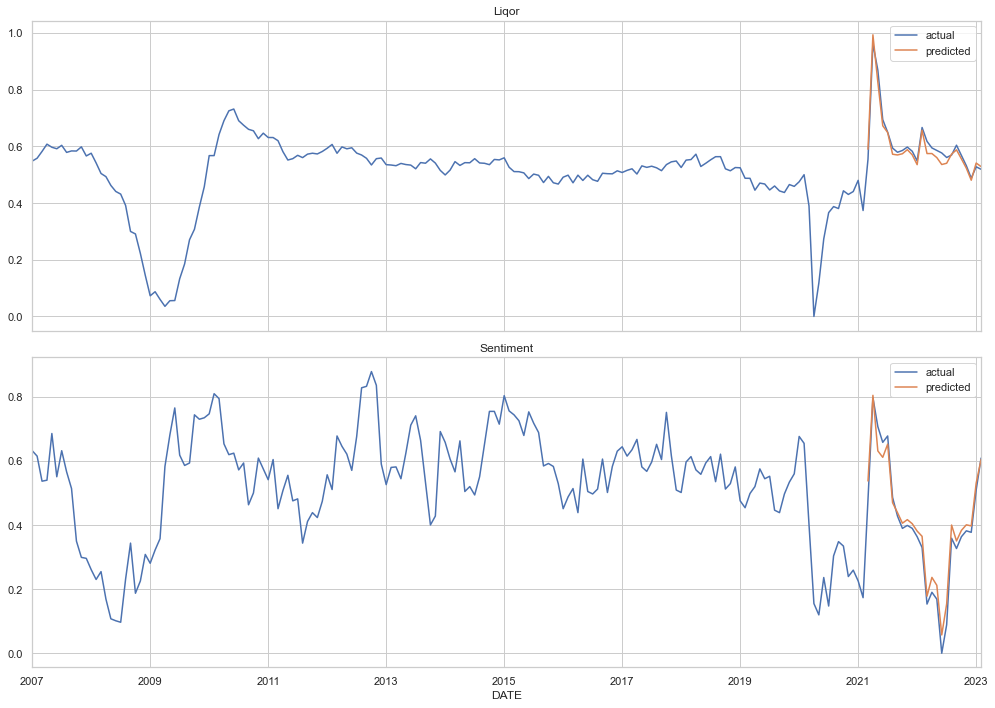

In [135]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 10), sharex=True)

df_transformed['2007':].ip.plot(ax=axes[0], label='actual', title='Liqor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2007':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
fig.tight_layout()

In [160]:
mean_absolute_error(forecast, df_transformed.iloc[530:])

0.13626351612419008